# Journal 2022-08-25
Look at interactive exploration of time series data in Jupyter notebook.  Start with [IPyWidgets](https://github.com/jupyter-widgets/ipywidgets) to do date selection of a financial data price time series using a [SelectionRangeSlider](https://stackoverflow.com/questions/46756911/ipywidgets-floatrangeslider-daterangeslider) 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import yfinance as yf
import ipywidgets as widgets

Try creating a data range slider to choose date range at daily resolution.  Follow the approach from the StackExchange posts above.

In [3]:
def make_slider(start='2018', end='2023'):
    dates = pd.date_range(start, end, freq='D')
    # Slider definition
    # options = dates.to_list()  # First attempt: raw datetime object.  Works but can't see end date
    options = [(d.strftime('%Y%m%d'), d) for d in dates]  # Second attempt: (label, item) list with date format
    opt_index = (0, len(options)-1)
    slider = widgets.SelectionRangeSlider(
        index=opt_index, 
        options=options,
        layout={'width': '500px'}
    )
    return slider

make_slider()

SelectionRangeSlider(index=(0, 1826), layout=Layout(width='500px'), options=(('20180101', Timestamp('2018-01-0…

In [4]:
from ftse_constituents import get_sector_history

In [5]:
df_p = get_sector_history()

[*********************100%***********************]  10 of 10 completed


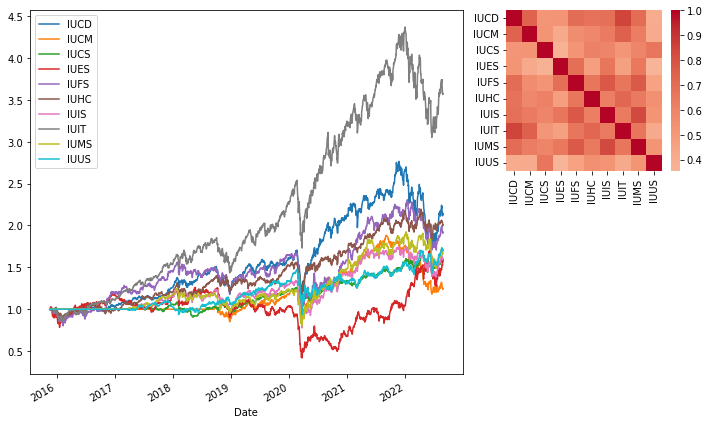

In [6]:
def select_date_range(df, date_range):
    return df['Adj Close'].loc[
        date_range[0]:date_range[-1], :
    ]

def plot_prices(date_range=None):
    fig = plt.figure(figsize=(10,6))
    gs = mpl.gridspec.GridSpec(nrows=2, ncols=3, figure=fig)
    ax = fig.add_subplot(gs[0:2,0:2])
    date_range = date_range if (date_range is not None) else df_p.index
    df_r = select_date_range(df_p, date_range).pct_change().fillna(0)
    df_r.rename(
        columns={c: c.replace('.L', '') for c in df_r.columns},
        inplace=True
    )
    df_n = (1 + df_r).cumprod()
    df_n.plot(ax=ax)
    # Add correlation plot
    ax_c = fig.add_subplot(gs[2])
    sns.heatmap(df_r.corr(), ax=ax_c, cmap='coolwarm', center=0.)
    plt.tight_layout()
plot_prices()

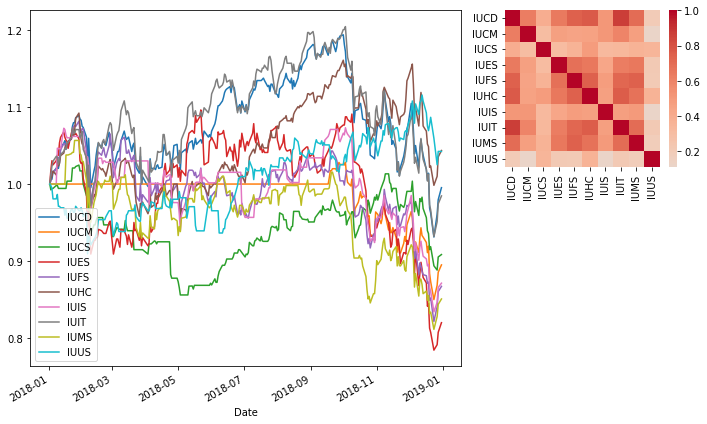

In [7]:
plot_prices(pd.date_range('2018', '2019', freq='D'))

In [8]:
_ = widgets.interact(plot_prices, date_range=make_slider('2018', '2023'))

interactive(children=(SelectionRangeSlider(description='date_range', index=(0, 1826), layout=Layout(width='500…

That seems to be working nicely, wrap it up in a class in ftse_constutuents module (which I should rename)

In [9]:
from ftse_constituents import TickerHistoryViewer

In [10]:
viewer = TickerHistoryViewer(df_p)
plot_fun = viewer.interactive('2019', '2020')

interactive(children=(SelectionRangeSlider(description='date_range', index=(0, 365), layout=Layout(width='500p…

In [11]:
plot_fun

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

The `viewer.interactive` method returns the output of the `widgets.interact` function, which is a function that can be used to produce a plot given the widget values.  This is normally tied to the widget (see cell above).

The time period 2019Q2 to 2019Q4 looks interesting - a rare case where some of the sectors have negative returns correlation.

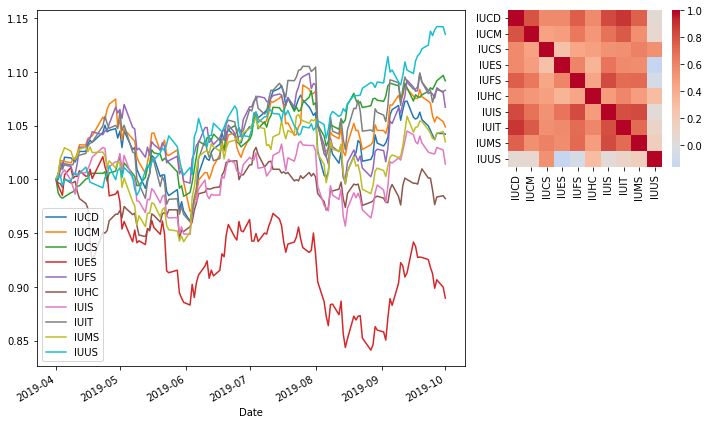

In [12]:
plot_fun(date_range=pd.date_range('20190401', '20191001'))

Have a closer look.  First calculate the rolling monthly correlation.

In [13]:
# Now implemented in viewer
# df_c = df_p['Adj Close'].pct_change().fillna(0.).rolling('21D').corr().dropna()

In [14]:
viewer.df_c.loc['2019-06-03']

,IUCD.L,IUCM.L,IUCS.L,IUES.L,IUFS.L,IUHC.L,IUIS.L,IUIT.L,IUMS.L,IUUS.L
IUCD.L,1.000000,0.882395,0.622628,0.705352,0.816677,0.754484,0.892825,0.911728,0.756314,-0.052660
IUCM.L,0.882395,1.000000,0.464004,0.573685,0.660443,0.551011,0.709528,0.808922,0.497488,-0.044546
IUCS.L,0.622628,0.464004,1.000000,0.403216,0.590354,0.723009,0.618811,0.507822,0.596787,0.509420
IUES.L,0.705352,0.573685,0.403216,1.000000,0.856854,0.649034,0.872830,0.795937,0.801832,0.189674
IUFS.L,0.816677,0.660443,0.590354,0.856854,1.000000,0.785640,0.910098,0.801067,0.799678,0.269123
IUHC.L,0.754484,0.551011,0.723009,0.649034,0.785640,1.000000,0.761548,0.694397,0.672793,0.454509
IUIS.L,0.892825,0.709528,0.618811,0.872830,0.910098,0.761548,1.000000,0.913173,0.936652,0.090288
IUIT.L,0.911728,0.808922,0.507822,0.795937,0.801067,0.694397,0.913173,1.000000,0.825865,0.011713
IUMS.L,0.756314,0.497488,0.596787,0.801832,0.799678,0.672793,0.936652,0.825865,1.000000,0.124712
IUUS.L,-0.052660,-0.044546,0.509420,0.189674,0.269123,0.454509,0.090288,0.011713,0.124712,1.000000


Then look at the correlation between say utilities and everything else.  For the time series plot things are a bit noisy so consider the 21 day rolling mean of the correlation.  Note that this means there is effectively a 42 day total lookback window at any given date, which may be suboptimal.

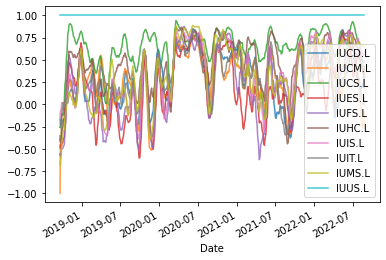

In [15]:
_ = viewer.df_c.xs('IUUS.L', level=1).rolling('21D').mean().plot(alpha=0.8)

Alternatively, look at the histogram of correlations. We can see that Utilities are usually highly correlated with Consumer Staples, and less correlated with Energy

In [16]:
viewer.df_c.columns[0]

'IUCD.L'

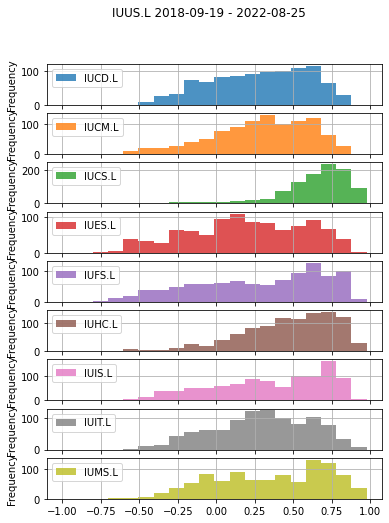

In [17]:
viewer.plot_corr(ref_ticker='IUUS.L')

In [18]:
viewer.df_c.xs('IUUS.L', level=1).drop(columns='IUUS.L').describe()

,IUCD.L,IUCM.L,IUCS.L,IUES.L,IUFS.L,IUHC.L,IUIS.L,IUIT.L,IUMS.L
count,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
mean,0.281633,0.288553,0.652260,0.192898,0.279349,0.469670,0.353408,0.296371,0.353116
std,0.318509,0.320528,0.212838,0.379618,0.417366,0.303256,0.369668,0.312305,0.366432
min,-0.513471,-1.000000,-0.263225,-0.738508,-0.713999,-0.577009,-0.581368,-0.510710,-0.732721
25%,0.033335,0.088939,0.547901,-0.076309,-0.051361,0.280030,0.082898,0.086039,0.065491
50%,0.314326,0.323696,0.695803,0.198178,0.359682,0.522578,0.400326,0.306113,0.392020
75%,0.545472,0.543218,0.800137,0.512795,0.634491,0.719317,0.688848,0.554106,0.675614
max,0.885809,0.852345,0.977129,0.901830,0.917322,0.950917,0.938420,0.914712,0.926024


See what things we like pre-COVID i.e. only look up to start of 2020

In [19]:
_ = viewer.interactive_corr(ref_ticker='IUUS.L')

interactive(children=(SelectionRangeSlider(description='date_range', index=(0, 1436), layout=Layout(width='500…

In [20]:
viewer.df_c.loc['2018':'2020', :].xs('IUUS.L', level=1).drop(columns='IUUS.L').describe()

,IUCD.L,IUCM.L,IUCS.L,IUES.L,IUFS.L,IUHC.L,IUIS.L,IUIT.L,IUMS.L
count,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,0.140875,0.151164,0.570393,0.002234,0.005713,0.319552,0.072299,0.160024,0.088731
std,0.273643,0.323308,0.253015,0.376616,0.362229,0.258381,0.298334,0.272190,0.305281
min,-0.513471,-1.000000,-0.263225,-0.719808,-0.659764,-0.450322,-0.542548,-0.510710,-0.732721
25%,-0.071476,-0.037791,0.455981,-0.301576,-0.273746,0.171240,-0.159748,-0.004887,-0.123214
50%,0.111464,0.161481,0.603635,0.029757,-0.033789,0.375192,0.084805,0.173503,0.059388
75%,0.354533,0.387586,0.769550,0.287335,0.263188,0.499625,0.268121,0.314479,0.263208
max,0.686357,0.737368,0.977129,0.785746,0.774366,0.828260,0.722129,0.817526,0.725699
